# An Introduction to Bayesian Quadrature with Emukit

## Overview

In [1]:
# General imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

# Figure config
LEGEND_SIZE = 15
FIGURE_SIZE = (12, 8)

### Navigation

1. [What is Bayesian quadrature?](#1.-What-is-Bayesian-quadrature?)

2. [The ingredients of Bayesian quadrature](#2.-The-quadrature-of-Bayesian-optimization)

3. [Emukit's Bayesian quadrature interface](#3.-Emukit's-Bayesian-quadrature-interface)

4. [References](#4.-References)

## 1. What is Bayesian quadrature?

We wish to integrate a function $f: \mathbb{X} \rightarrow \mathbb{R}$, $x\mapsto f(x)$ which is defined on some input space $\mathbb{X}\subseteq\mathbb{R}^D$

$$
F : = \int_{\mathbb{X}}f(x)\mathrm{d}x.
$$

The domain $\mathbb{X}$ can equally be defined by the integral bounds, i.e., $bounds = \{(lower\_bound_d, upper\_bound_d)\}_{d=1}^D$. The function $f$ is called the *integrand*. Integration problems occur for example when computing estimators of some quantity or when marginalizing a probability distribution. Numerical solvers are needed whenever $f(x)$ is not integrable analytically.

Bayesian quadrature (BQ) [[1, 2]](#4.-References) is a numerical method that infers the value of the integral $F$ from a finite number of usually noise-free integrand evaluations $f(x_n)$, at locations $x_n$, $n=1, ...,N$. It does so by first emulating the integrand function $f$ with a surrogate model.
Then, an estimate for $F$ is obtained by integrating the surrogate model of $f$. 
The key point is that the integration of the surrogate model is much easier, often analytic, in comparison to the original integration problem. Hence BQ shifts the problem of solving a hard integration problem to a regression problem on the integrand and an easier, often analytic integration problem of the regression model.


#### Surrogate model of the integrand
The surrogate for the integrand $f$ is often a Gaussian process (GP) which can be integrated analytically if the kernel of the GP can be integrated analytically; an example of such a kernel is the RBF/Gaussian kernel. Sometimes also a process related to a Gaussian process is used as surrogate (e.g., [[3]](#4.-References)), then the surrogate is approximated with yet another GP which can then be integrated again. 

#### Distribution over the integral value
Bayesian quadrature returns a *distribution* over the integral value $F$, not only an estimate of the integral value. An estimate can then be deduced, e.g., by taking the maximum a posteriori (MAP). If a GP is used as surrogate for $f$ then the integral distribution is of Gaussian form $F\sim\mathcal{N}(\mathfrak{m}_n, \mathfrak{v}_n)$. We obtain a distribution on $F$ because the model on the integrand $f$ was a distribution in the first place. A benefit of a distribution as return type in contrast to an estimator only is that a distribution also quantifies the uncertainty on the integral estimation. 

The integral distribution $F\sim\mathcal{N}(\mathfrak{m}_n, \mathfrak{v}_n)$ is exact and a Gaussian due to the closeness property of GPs under affine transformations. The univariate mean and variance of the integral distribution are respectively

$$
\mathfrak{m}_n = \int_{\mathbb{X}} \mu_n(x)\mathrm{d}x, \qquad\qquad
\mathfrak{v}_n = \int_{\mathbb{X}} \int_{\mathbb{X}}^3 k_n(x, x')\mathrm{d}x\mathrm{d}x'.
$$

We can obtain the mean $\mathfrak{m}_n$ and variance $\mathfrak{v}_n$ of the integral distribution analytically if we know the analytic forms of the integral over the GP posterior mean function $\mu_n(x)$ and the double integral over the posterior covariance function $k_n(x, x')$; this is fulfilled e.g., by the RBF kernel. 

#### Acquiring data

In practice, integrand evaluation $f(x_n)$ can be expensive and we are restricted to a limited budged of $N$ choices of locations $x_n$ at which we can evaluate $f$.
Thus we would like to choose these locations wisely, or some best way possible. What 'best' means is encoded in a user-defined utility which is equal to, or approximated by an *acquisition* function $a_n(x)$. The acquisition function always has knowledge of the current model of the integrand, in this case the GP on $f$ with mean $\mu_n$ and kernel $k_n$.

The integral $F$ is a global property of $f$, meaning that local information of $f$ can not be used alone to meaningfully guess $F$. This is reflected in the acquisition functions that are commonly used in BQ--they, too, are commonly global quantities. Examples are the integral-variance-reduction or the mutual information between the integral value and an additional hypothetically collected point at location $x$, i.e., 

$$
x_{n+1} \in  \operatorname*{arg\:max}_{x \in \mathbb{X}} a_n(x).
$$



Given the surrogate GP on $f$, the acquisition function $a$, and a function handle to $f(x)$, BQ essentially iterates the following three steps until the budget of $N$ evaluations is used up: 
1. fit the GP $p(f|D_n)$ on the currently available dataset $D_n\{(f(x_i), x_i)\}_{i=1}^n$.
2. condition the acquisition function $a_n(x)$ on $p(f|D_n)$ and find the maximizer, i.e., $x_{n+1} = \operatorname*{arg\:max}_{x \in \mathbb{X}} a_n(x)$.
3. evaluate the objective function at $x_{n+1}$ to obtain $f(x_{n+1})$, and add the new observation to the dataset $D_{n+1} \leftarrow D_{n} \cup \{x_{n+1}, f(x_{n+1})\}$.



## 2. The ingredients of Bayesian quadrature

<h4 id='bo_intro_objective'>The Objective Function and the Input Space</h4>

As an example let's assume we want to integrate the one-dimensional function $f(x) = e^{-x^2 - \sin^2(2x)}$ over the interval $\mathbb{X}=[-3, 3]$, i.e.,

$$
F = \int_{-3}^{3}e^{-x^2 - \sin^2(2x)}\mathrm{d}x.
$$

Conveniently, this function is already implemented in Emukit. 

In [2]:
from emukit.test_functions.quadrature import hennig1D

user_function, integral_bounds = hennig1D()

Of course in reality, evaluating $f$ on a grid wouldn't be possible, but since the hennig1D function is a synthetic function we can evaluate it here for visualization purposes on the interval defined by the integral bounds. 

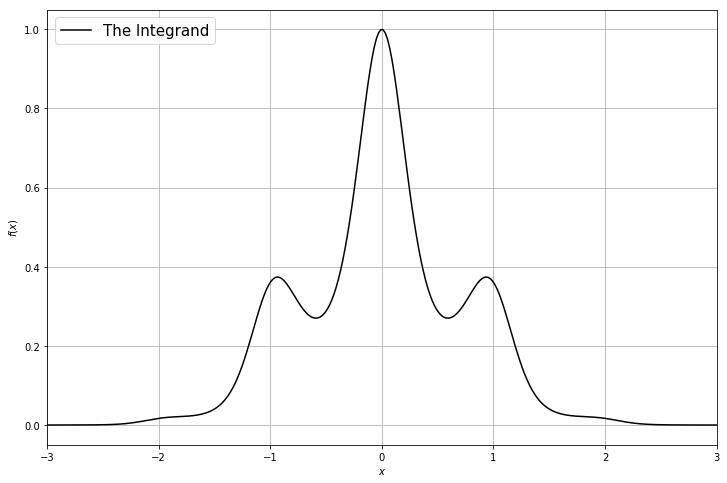

In [3]:
lb = integral_bounds[0][0] # lower bound
ub = integral_bounds[0][1] # upper bound

x_plot = np.linspace(lb, ub, 300)[:, None]
y_plot = user_function.f(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot, y_plot, "k", label="The Integrand")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(lb, ub)
plt.show()

#### Ground truth

For the sake of demonstration we compute the ground truth integral here to high precision. In real-world tasks, this is not possible which is why we need a method like BQ in the first place.

In [4]:
from emukit.test_functions.quadrature.baselines import univariate_approximate_ground_truth_integral

ground_truth = univariate_approximate_ground_truth_integral(user_function.f, (lb, ub))[0]

<h4 id='bo_intro_init_design'> The Intial Design </h4>

Usually, before we start the actual BQ loop we need to gather a few observations such that we can fit an initial GP-model. This is called the initial design and common strategies are either a predefined grid or sampling points uniformly at random. 

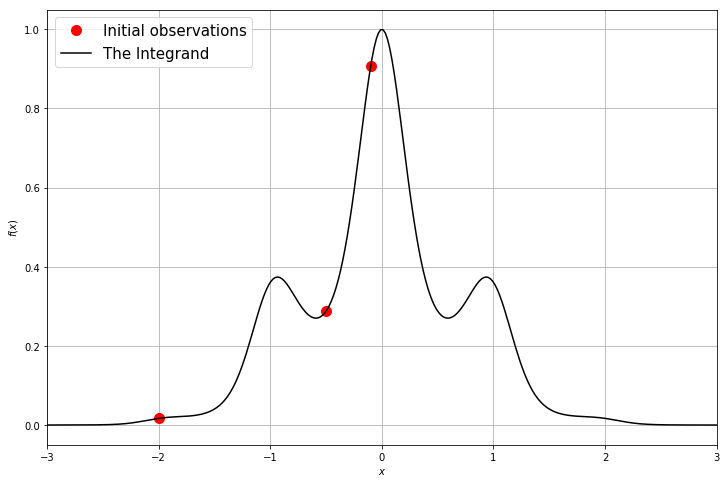

In [5]:
X_init = np.array([[-2.],[-0.5], [-0.1]])
Y_init = user_function.f(X_init)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(X_init, Y_init, "ro", markersize=10, label="Initial observations")
plt.plot(x_plot, y_plot, "k", label="The Integrand")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(lb, ub)
plt.show()

<h4 id='bo_intro_model'> The Model </h4>
        

Now we can start with the BQ loop by first fitting a model on the collected data. 
The arguably most popular model for BQ is a Gaussian process (GP) which defines a probability distribution across classes of functions, such that each linear finite-dimensional restriction is multivariate Gaussian (see e.g., [[4]](#4.-References)). GPs are fully parametrized by a mean function $\mu(x)$ and a covariance function $k(x,x')$.  

In BQ, the kernel choice is more restricted than, for example in Bayesian optimization, since BQ requires access to analytic integrals of the kernel function. Luckily, the RBF-kernel 

$$ 
k(x,x') = \theta_0 \cdot \exp{ \left(-\frac{\|x-x'\|^2}{\theta_1}\right)}\quad \text{with}\quad \theta_0,~\theta_1\quad \text{hyperparameters},
$$

is integrable analytically and is also a standard choice in many applications.
To denote that $f$ is a sample from a GP conditioned on the dataset $D_n$ with mean function $\mu_n(x)$ and covariance function $k_n(x, x')$ we write $f \sim \mathcal{GP}(\mu_n,k_n).$


Note that the Gaussian process model class can also be characterized by its hyperparameters $\theta = \{\theta_0, ... \theta_k\}$ such as for instance the kernel lengthscales. For simplicity we keep these hyperparameters fixed here. However, we usually either optimize or sample these hyperparameters using the marginal log-likelihood of the GP. 

#### Make your GP model 

We use a GPy GP regression model with RBF kernel as surrogate for $f$.

In [6]:
import GPy

# GPy takes X and Y values at initialization. Those will be overwritten later when the emukit model is initialized.
gpy_model = GPy.models.GPRegression(X=X_init, Y=Y_init, kernel=GPy.kern.RBF(
                        input_dim=X_init.shape[1], lengthscale=0.5, variance=1.0))

#### Convert to Emukit quadrature model

We use the GPy GP wrapper which is already in Emukit to convert the GPy model into an Emukit model. But you can also use your own model and wrap it using Emukit interfaces.

We first wrap the RBF kernel of GPy and obtain the Emukit RBF kernel `emukit_rbf`. Then we create the quadrature RBF kernel `emukit_qrbf` which has additional functionality needed for BQ. Then we create an Emukit GP `emukit_model` with this quadrature kernel. Note that we need to wrap the kernel, too, since the integration that BQ performs is essentially equal to integrating the kernel.

In [7]:
from emukit.model_wrappers.gpy_quadrature_wrappers import BaseGaussianProcessGPy, RBFGPy
from emukit.quadrature.kernels import QuadratureRBFnoMeasure

emukit_rbf = RBFGPy(gpy_model.kern)
emukit_qrbf = QuadratureRBFnoMeasure(emukit_rbf, integral_bounds=integral_bounds)
emukit_model = BaseGaussianProcessGPy(kern=emukit_qrbf, gpy_model=gpy_model)

#### Choose the quadrature method: Vanilla BQ

The vanilla BQ method performs GP regression on the integrand $f$ itself which is the most simple way of doing BQ; then this GP is integrated. 
Emukit can perform the integration of the GP without approximations. But first, we plot the marginal distributions of the GP alongside the integrand, as well as the distribution over the integral value $F$. 

In [8]:
from emukit.quadrature.methods import VanillaBayesianQuadrature

emukit_method = VanillaBayesianQuadrature(base_gp=emukit_model, X=X_init, Y=Y_init)

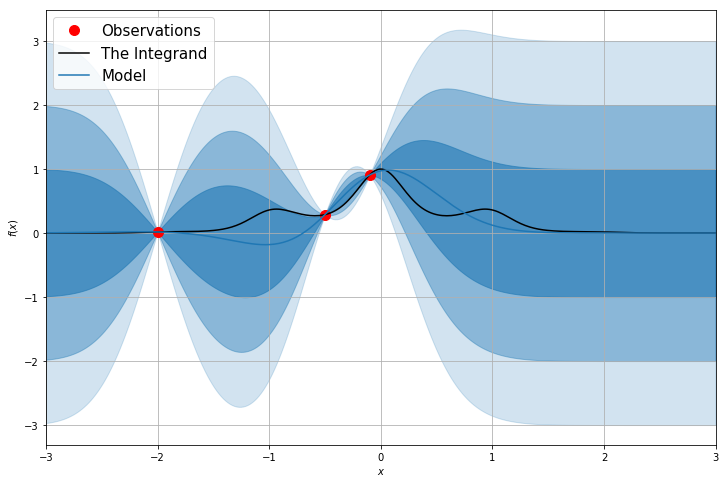

In [9]:
mu_plot, var_plot = emukit_method.predict(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(X_init, Y_init, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="The Integrand")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(lb, ub)
plt.show()

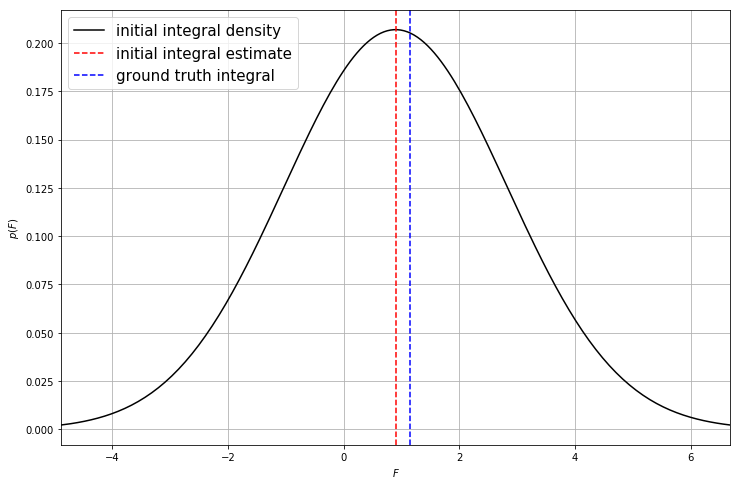

In [10]:
initial_integral_mean, initial_integral_variance = emukit_method.integrate()

x_plot_integral = np.linspace(initial_integral_mean-3*np.sqrt(initial_integral_variance), 
                              initial_integral_mean+3*np.sqrt(initial_integral_variance), 200)
y_plot_integral_initial = 1/np.sqrt(initial_integral_variance * 2 * np.pi) * \
np.exp( - (x_plot_integral - initial_integral_mean)**2 / (2 * initial_integral_variance) )
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot_integral, y_plot_integral_initial, "k", label="initial integral density")
plt.axvline(initial_integral_mean, color="red", label="initial integral estimate", \
            linestyle="--")
plt.axvline(ground_truth, color="blue", label="ground truth integral", \
            linestyle="--")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$F$")
plt.ylabel(r"$p(F)$")
plt.grid(True)
plt.xlim(np.min(x_plot_integral), np.max(x_plot_integral))
plt.show()

We observe that the error in the integral value is still large after only three initial evaluations, but the true integral value is well within the error bars. 

In [11]:
print('The initial estimated integral is: ', round(initial_integral_mean, 2))
print('with a credible interval: ', round(2*np.sqrt(initial_integral_variance), 2), '.')
print('The ground truth rounded to 2 digits for comparison is: ', round(ground_truth, 2), '.')

The initial estimated integral is:  0.9
with a credible interval:  3.86 .
The ground truth rounded to 2 digits for comparison is:  1.14 .


<h4 id='bo_intro_acquisition'> The Acquisition Function </h4>

In the second step of our BQ loop we use our model to compute the acquisition function. In BQ, the acquisition function is ideally a global property of the integrand $f$ since the integral $F$ is, too. Two common acquisition functions of BQ are:


**Integral variance reduction (IVR)**: The IVR is the difference between the current variance $\mathfrak{v}_n$ of the integral distribution and the variance of the integral distribution after another hypothetically collected datapoint at $x$
That is, IVR maximizes

$$
a_n^{IVR}(x) = \mathfrak{v}_n - v[\{x_i\}_{i=1}^n\cup x]= \mathfrak{v}_n \rho^2(x),
$$ 

where $v[\{x_i\}_{i=1}^n\cup x]$ is the integral variance under the newly collected point $x$, and  
$$
\rho^2(x) = \frac{\left(\int_{\mathbb{X}} k_n(z, x)\mathrm{d}z\right)^2}{\mathfrak{v}_n v_n(x)}
$$ 

is the squared correlation between the integral value and the hypothetical integrand value at $x$, and $v_n(x)$ is the variance of $f(x)$. Note that we can normalize the IVR by the current variance $\mathfrak{v}_n$ of the integral which does not depend on $x$. Like this, the normalized IVR ranges between 0 and 1 and is indeed equal to the squared correlation itself.



**Mutual Information (MI)**: This acquisition function builds on an information theoretic approach. MI is the mutual information $I(F; f(x))$ between the integral value and the value of the hypothetically collected datapoint $f(x)$. That is, MI maximizes

$$
a_n^{MI}(x) = I(F; f(x)) = -\frac{1}{2}\log\left[1-\rho^2(x)\right].
$$

In vanilla BQ, both IVR and MI are identical in the sense that their armax that yields $x_{n+1}$ is identical, i.e., the location of their global optimum is the same. This can be seen since IVR is a transformation of MI by the strictly monotonic function $1-e^{-2a^{MI}}$.
Since the policy of the acquisition scheme (choosing the argmax of $a_n(x)$) is independent of the values of $a_n(x)$ we can thus use IVR and MI interchangeably for vanilla BQ (note that this might be not the case for cost-sensitive models). In this tutorial we will use the normalized IVR.

The acquisition functions presented here only rely on the model and hence are cheap to evaluate. Furthermore we can easily compute the gradients and use a simple gradient based optimization method to find $x_{n+1} \in \operatorname*{arg\:max}_{x \in \mathbb{X}} a_n(x)$.

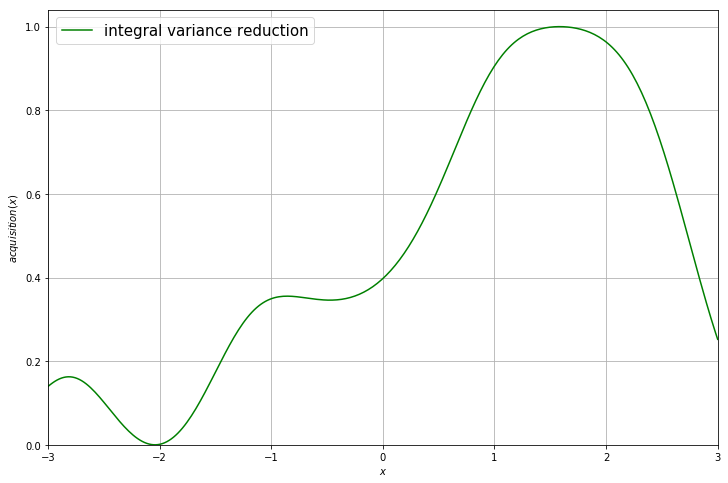

In [12]:
from emukit.quadrature.acquisitions import IntegralVarianceReduction

ivr_acquisition = IntegralVarianceReduction(emukit_method)

ivr_plot = ivr_acquisition.evaluate(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot, (ivr_plot - np.min(ivr_plot)) / (np.max(ivr_plot) - np.min(ivr_plot)), 
         "green", label="integral variance reduction")

plt.legend(loc=0, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$acquisition(x)$")
plt.grid(True)
plt.xlim(lb, ub)
plt.ylim(0, 1.04)
plt.show()

<h4 id='bo_intro_eval'> Evaluating the objective function </h4>

To find the next point to evaluate we optimize the acquisition function using a standard gradient descent optimizer.

The `space` object defines the input space for the optimizer which, in the case of BQ, is equal to the integration domain defined by the integral bounds, i.e., $\mathbb{X} = [-3, 3]$. Note that the maximum of the acquisition does *not* appear at the integral bounds where the variance on $f$ is highest. This is because evaluations on the bounds would not maximally reduce what we learn about the integral, a global property; this behavior precisely illustrates the difference of a local vs a global acquisition strategy.

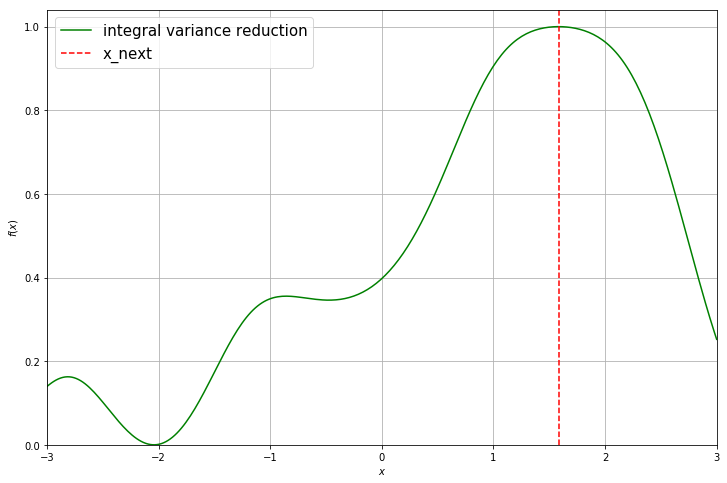

In [13]:
from emukit.core.optimization import GradientAcquisitionOptimizer
from emukit.core.parameter_space import ParameterSpace

space = ParameterSpace(emukit_method.integral_parameters)
optimizer = GradientAcquisitionOptimizer(space)
x_new,_ = optimizer.optimize(ivr_acquisition)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot, (ivr_plot - np.min(ivr_plot)) / (np.max(ivr_plot) - np.min(ivr_plot)), 
         "green", label="integral variance reduction")
plt.axvline(x_new, color="red", label="x_next", linestyle="--")
plt.legend(loc=0, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(lb, ub)
plt.ylim(0, 1.04)
plt.show()

Afterwards we evaluate the true objective function and append it to our initial observations.

In [14]:
y_new = user_function.f(x_new)

In [15]:
X = np.append(X_init, x_new, axis=0)
Y = np.append(Y_init, y_new, axis=0)

After updating the model, you can see that the uncertainty about the true objective function in this region decreases and our model becomes more certain. We have also reduces the variance on the integral estimation as can be seen from the plot below.

In [16]:
emukit_method.set_data(X, Y)

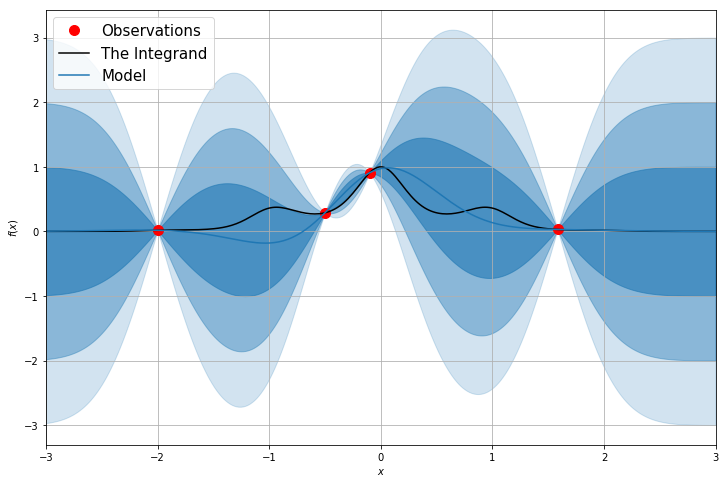

In [17]:
mu_plot, var_plot = emukit_model.predict(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(emukit_model.X, emukit_model.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="The Integrand")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(lb, ub)
plt.show()

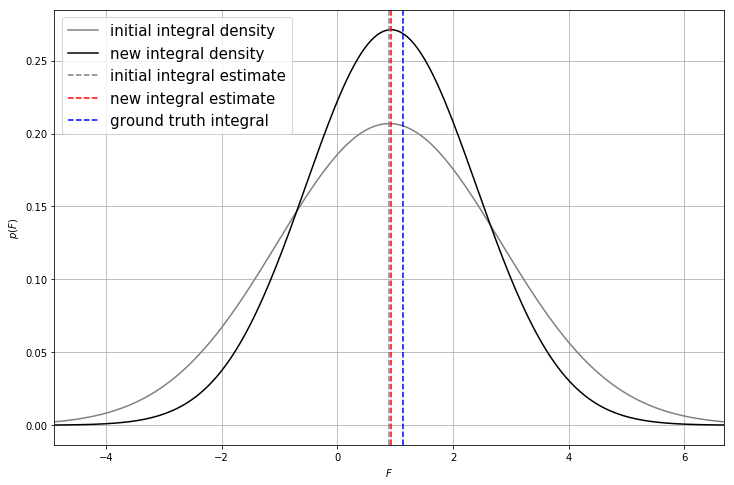

In [18]:
integral_mean, integral_variance = emukit_method.integrate()

y_plot_integral = 1/np.sqrt(integral_variance * 2 * np.pi) * \
np.exp( - (x_plot_integral - integral_mean)**2 / (2 * integral_variance) )
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot_integral, y_plot_integral_initial, "gray", label="initial integral density")
plt.plot(x_plot_integral, y_plot_integral, "k", label="new integral density")
plt.axvline(initial_integral_mean, color="gray", label="initial integral estimate", linestyle="--")
plt.axvline(integral_mean, color="red", label="new integral estimate", linestyle="--")
plt.axvline(ground_truth, color="blue", label="ground truth integral", \
            linestyle="--")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$F$")
plt.ylabel(r"$p(F)$")
plt.grid(True)
plt.xlim(np.min(x_plot_integral), np.max(x_plot_integral))
plt.show()

In [19]:
print('The estimated integral is: ', round(integral_mean, 2))
print('with a credible interval: ', round(2*np.sqrt(integral_variance), 2), '.')
print('The ground truth rounded to 2 digits for comparison is: ', round(ground_truth, 2), '.')

The estimated integral is:  0.93
with a credible interval:  2.94 .
The ground truth rounded to 2 digits for comparison is:  1.14 .


## 3. Emukit's Bayesian quadrature interface

Of course in practice we don't want to implement all of these steps our self. Emukit provides a convenient and flexible interface to apply Bayesian quadrature. Below we can see how to run vanilla Bayesian quadrature on the exact same function for 20 iterations.

We see that the model is now very certain about the integral value which can be seen from the narrow density. In comparison, the initial integral density using three points only (shown in gray) is very wide and flat and more uncertain.

In [20]:
from emukit.examples.vanilla_bayesian_quadrature_with_rbf.vanilla_bq_loop_with_rbf import create_vanilla_bq_loop_with_rbf_kernel

emukit_loop = create_vanilla_bq_loop_with_rbf_kernel(X=X_init, Y=Y_init, 
                                                     integral_bounds=integral_bounds,
                                                     measure=None)
emukit_loop.run_loop(user_function=user_function, stopping_condition=20)

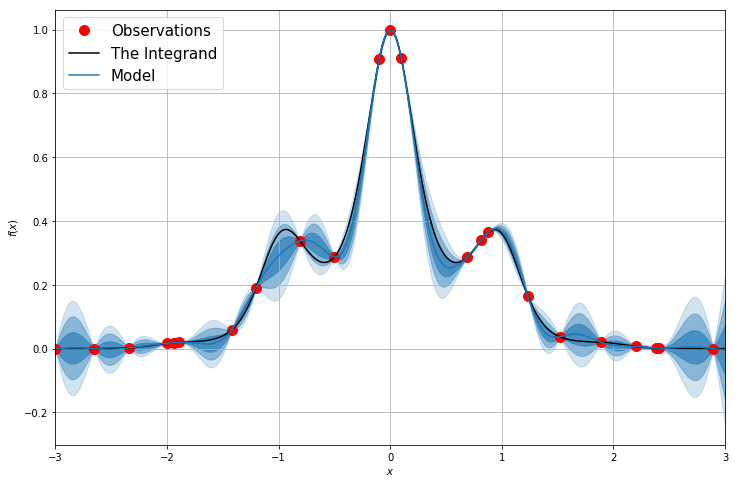

In [21]:
mu_plot, var_plot = emukit_loop.model.predict(x_plot)

plt.figure(figsize=FIGURE_SIZE)
plt.plot(emukit_loop.loop_state.X, emukit_loop.loop_state.Y, "ro", markersize=10, label="Observations")
plt.plot(x_plot, y_plot, "k", label="The Integrand")
plt.plot(x_plot, mu_plot, "C0", label="Model")
plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color="C0", alpha=0.6)

plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.4)

plt.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color="C0", alpha=0.2)
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.grid(True)
plt.xlim(lb, ub)

plt.show()

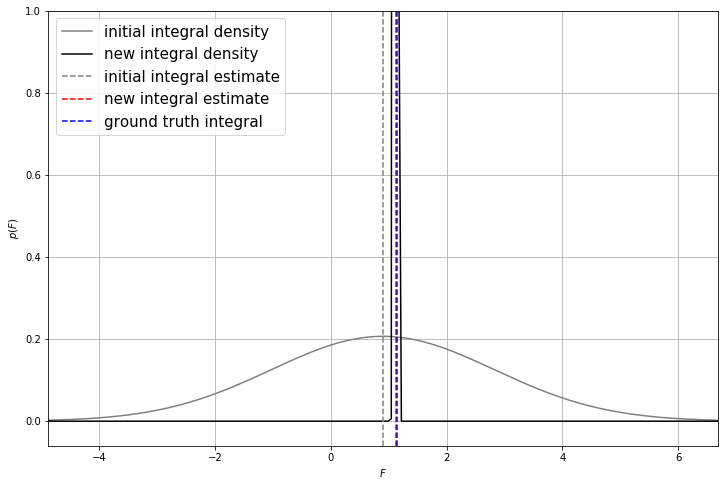

In [22]:
integral_mean, integral_variance = emukit_loop.model.integrate()

y_plot_integral = 1/np.sqrt(integral_variance * 2 * np.pi) * \
np.exp( - (x_plot_integral - integral_mean)**2 / (2 * integral_variance) )
plt.figure(figsize=FIGURE_SIZE)
plt.plot(x_plot_integral, y_plot_integral_initial, "gray", label="initial integral density")
plt.plot(x_plot_integral, y_plot_integral, "k", label="new integral density")
plt.axvline(initial_integral_mean, color="gray", label="initial integral estimate", linestyle="--")
plt.axvline(integral_mean, color="red", label="new integral estimate", linestyle="--")
plt.axvline(ground_truth, color="blue", label="ground truth integral", \
            linestyle="--")
plt.legend(loc=2, prop={'size': LEGEND_SIZE})
plt.xlabel(r"$F$")
plt.ylabel(r"$p(F)$")
plt.grid(True)
plt.xlim(np.min(x_plot_integral), np.max(x_plot_integral))
plt.ylim(-0.06, 1)
plt.show()

In [23]:
print('The estimated integral is: ', round(integral_mean, 2))
print('with a credible interval: ', round(2*np.sqrt(integral_variance), 2), '.')
print('The ground truth rounded to 2 digits for comparison is: ', round(ground_truth, 2), '.')

The estimated integral is:  1.12
with a credible interval:  0.04 .
The ground truth rounded to 2 digits for comparison is:  1.14 .


## 4. References

- [1] O'Hagan (1991) [Bayes-Hermite Quadrature](https://www.sciencedirect.com/science/article/pii/037837589190002V), *Journal of Statistical Planning and Inference* 29, pp. 245--260.
- [2] Diaconis (1988) [Bayesian numerical analysis](http://probabilistic-numerics.org/assets/pdf/Diaconis_1988.pdf), *Statistical decision theory and related topics* V, pp. 163--175.
- [3] Gunter et al. (2014) [Sampling for Inference in Probabilistic Models with Fast Bayesian Quadrature](https://papers.nips.cc/paper/5483-sampling-for-inference-in-probabilistic-models-with-fast-bayesian-quadrature), *Advances in Neural Information Processing Systems*, 27, pp. 2789--2797.
- [4] Rasmussen and Williams (2005) [Gaussian Processes for Machine Learning](http://www.gaussianprocess.org/gpml/chapters/RW.pdf) *Adaptive Computation and Machine Learning*, The MIT Press
